Using /tmp/torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /tmp/torch_extensions/gp_interp_cuda/build.ninja...
Building extension module gp_interp_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module gp_interp_cuda...
Num coords: 4
Doing a forward pass...
Doing a backward pass...
Loss: 0.12815387547016144
Success!


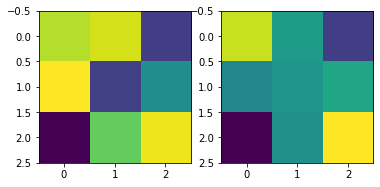

In [1]:
from torch.utils.cpp_extension import load

gp_interp_cuda = load('gp_interp_cuda', ['gp_interp_cuda.cpp', 'gp_interp_cuda_kernel.cu'], verbose=True)

import sys; sys.path.extend(['.', '../cuda'])

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TVF

from gp_interp import GPInterp

device = 'cuda'
# img_pil = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png')
# img_pil = Image.open('./water.jpg')
# img = TVF.to_tensor(img_pil).to(device)
size = 3
img = torch.linspace(1, 0, size).view(-1, 1).repeat(1, size).unsqueeze(2).to(device).permute(2, 0, 1)
torch.manual_seed(42)
img = torch.rand_like(img.cpu()).to(img.device)
gp = GPInterp(img.shape[1], img.shape[2], 0.8, 1.0, 1)
# gp.means = nn.Parameter(torch.tensor([[1.0, 1.0]]))
gp.to(device)

print('Num coords:', len(gp.means))

print('Doing a forward pass...')
out = gp(img)

print('Doing a backward pass...')
loss = (out - img).abs().mean()
loss.backward()
print('Loss:', loss.item())
print('Success!')

# TVF.to_pil_image(out.cpu())
plt.subplot(121)
plt.imshow(img[0].detach().cpu())

plt.subplot(122)
plt.imshow(out[0].detach().cpu())

In [2]:
gp.means.grad

tensor([[-0.0061, -0.0061],
        [ 0.0027,  0.0186],
        [-0.0018,  0.0018],
        [ 0.0065, -0.0457]], device='cuda:0')

In [126]:
tqdm._instances.clear()

  0%|          | 20/5000 [00:00<00:51, 96.28it/s]

0.00152


 10%|█         | 522/5000 [00:04<00:38, 115.56it/s]

0.00141


 20%|██        | 1014/5000 [00:08<00:34, 115.89it/s]

0.00138


 30%|███       | 1518/5000 [00:13<00:30, 115.57it/s]

0.00137


 40%|████      | 2022/5000 [00:17<00:25, 114.84it/s]

0.00136


 50%|█████     | 2514/5000 [00:21<00:21, 115.45it/s]

0.00136


 60%|██████    | 3018/5000 [00:26<00:17, 114.90it/s]

0.00136


 70%|███████   | 3522/5000 [00:30<00:12, 115.30it/s]

0.00136


 80%|████████  | 4014/5000 [00:34<00:08, 115.21it/s]

0.00136


 90%|█████████ | 4518/5000 [00:39<00:04, 115.39it/s]

0.00136


100%|██████████| 5000/5000 [00:43<00:00, 115.38it/s]

diff passed: tensor(32.5364, device='cuda:0', grad_fn=<MeanBackward0>)


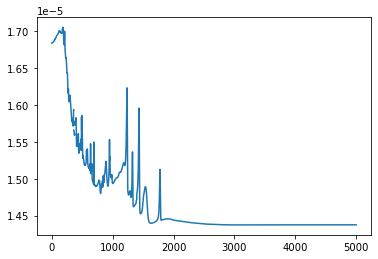

In [127]:
from tqdm import tqdm

# img_pil = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png')
img_pil = Image.open('./water.jpg')
img = TVF.to_tensor(img_pil).to(device)
gp = GPInterp(img.shape[1], img.shape[2], 0.2, 1.0, 5)
gp.to(device)
means_old = gp.means.data.cpu().tolist()
optim = torch.optim.SGD(gp.parameters(), lr=100.0, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=500, gamma=0.333)
# optim = torch.optim.Adam(gp.parameters(), lr=1000.0)
grad_norms = []
for i in tqdm(range(5000)):
    out = gp(img)
    loss = (out - img).pow(2).mean()
    optim.zero_grad()
    loss.backward()
    if np.isnan(gp.means.grad.max().item()):
        print('NaN grad!')
        break
    #torch.nn.utils.clip_grad_norm_(gp.parameters(), 10.0)
    if np.isnan(gp.means.grad.max().item()):
        print('NaN grad after ...!')
        break
    grad_norms.append(gp.means.grad.norm().item())
    optim.step()
    if np.isnan(gp.means.max().item()):
        print('NaN weight!')
        break
    scheduler.step()
    gp.means.data[:,0].clamp_(0.0, img.shape[2])
    gp.means.data[:,1].clamp_(0.0, img.shape[1])
    if i % 500 == 0:
        print(f'{loss.item():.05f}')
        
print('diff passed:', (torch.tensor(means_old).to(device) - gp.means).pow(2).mean())
plt.plot(grad_norms)

In [131]:
# TVF.to_pil_image(GPInterp(img.shape[1], img.shape[2], 0.2, 1.0, 5).cuda()(img).cpu())

In [130]:
# TVF.to_pil_image(out.cpu())